In [135]:
import torch
import pandas as pd
from torch import nn
from pathlib import Path
import json
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [136]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")

In [172]:
# Read session and label

session_idx = 31

df = pd.read_csv(
    Path(raw_dir, f'{session_idx}', 'raw_data.csv'), 
    header=None,
    usecols=[2,3,4]
)

labels = json.load(
    Path(label_dir, f'{session_idx}_data.json').open()
)

X = torch.Tensor(df.values)
y = torch.zeros(len(X))
print(X.shape)
y[labels['start']:labels['end']] = 1
X = nn.functional.pad(X, (0, 0, 50,50), "constant", 0)
print(X.shape)
y = nn.functional.pad(y, (50,50), "constant", 0)
window_session(X, 100).shape
# X = X.view(-1, 100, 3)
# y = y.view(-1, 100, 1).mode(dim=1).values

torch.Size([115000, 3])
torch.Size([115100, 3])


torch.Size([115001, 300])

In [162]:
def window_session(session: torch.Tensor, winsize: int) -> torch.Tensor:
    # Input shape: L x 3
    # Output shape: L x 3*WINSIZE

    # Window session
    x_acc = session[:,0].unsqueeze(1)
    y_acc = session[:,1].unsqueeze(1)
    z_acc = session[:,2].unsqueeze(1)

    w = winsize-1

    xs = [x_acc[:-w]]
    ys = [y_acc[:-w]]
    zs = [z_acc[:-w]]

    for i in range(1,w):
        xs.append(x_acc[i:i-w])
        ys.append(y_acc[i:i-w])
        zs.append(z_acc[i:i-w])

    xs.append(x_acc[w:])
    ys.append(y_acc[w:])
    zs.append(z_acc[w:])

    xs = torch.cat(xs,axis=1).float()
    ys = torch.cat(ys,axis=1).float()
    zs = torch.cat(zs,axis=1).float()

    X = torch.cat([xs,ys,zs], axis=1)
    return X


window_session(X, winsize=100)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  9.7188,  9.9453,  9.6484],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9453,  9.6484,  9.4922],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.6484,  9.4922,  9.6016],
        ...,
        [-0.1604, -0.1484, -0.1388,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1484, -0.1388, -0.1460,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1388, -0.1460, -0.1675,  ...,  0.0000,  0.0000,  0.0000]])

In [122]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(in_features=300, out_features=10)
        self.relu = nn.ReLU()
        self.out = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.h1(x)
        x = self.relu(x)
        x = self.out(x)
        return x


model = MLP().to('cuda')
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

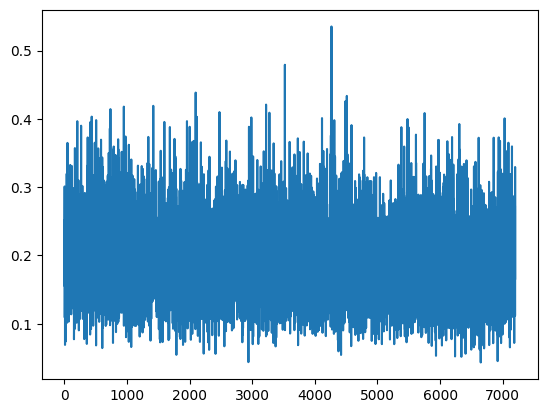

In [133]:
loader = DataLoader(TensorDataset(X,y), batch_size=64, shuffle=True)


losses = []
for i in range(400):
    for Xi,yi in loader:
        Xi,yi = Xi.to('cuda'), yi.to('cuda')
        logits = model(Xi)
        loss = criterion(logits, yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

plt.plot(losses)

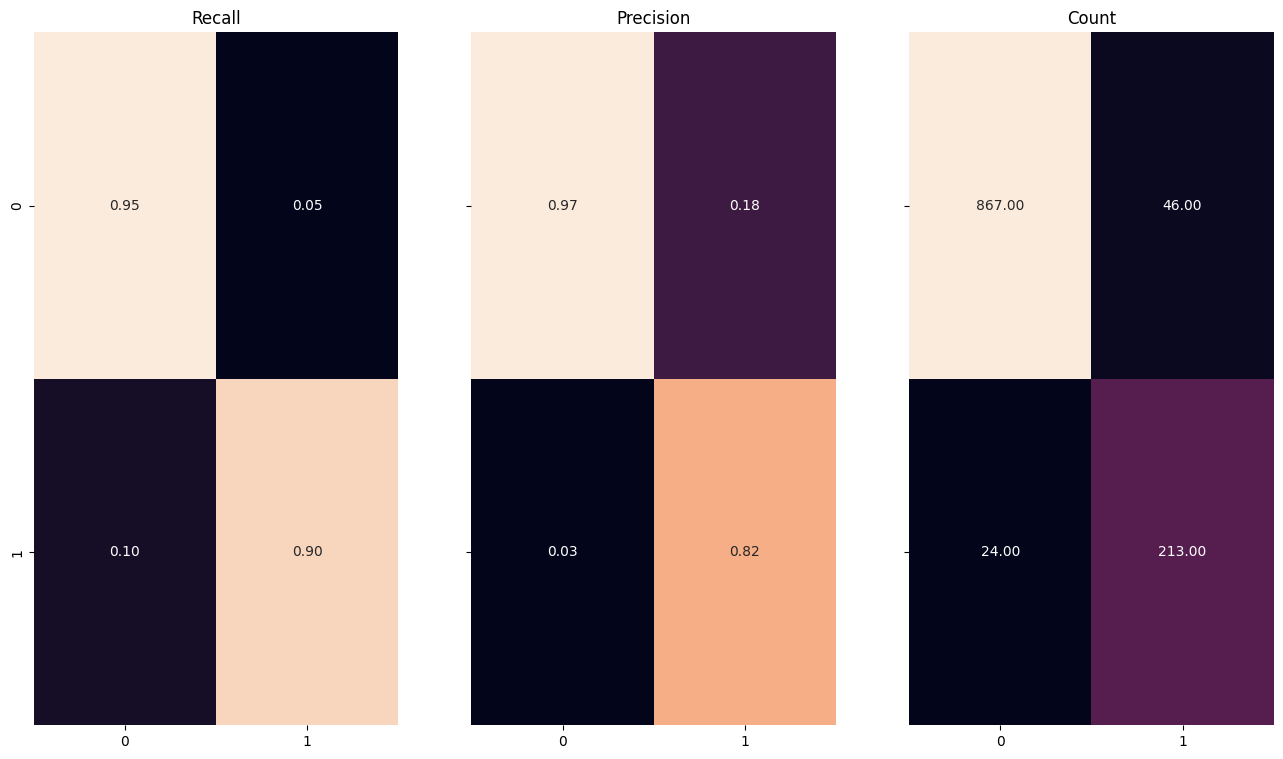

In [134]:
loss, report, y_true,y_pred,y_logits  = evaluate(loader, model, criterion)
plot_and_save_cm(y_true, y_pred)

In [127]:
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix
def metrics(y_true,y_pred):
    return {
        'precision':precision_score(y_true=y_true,y_pred=y_pred,average='macro'),
        'recall':recall_score(y_true=y_true,y_pred=y_pred,average='macro'),
        'f1':f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    }
def evaluate(dataloader,model,criterion,DEVICE='cuda'):
    model.eval()
    with torch.no_grad():
        y_true = torch.Tensor()
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        loss_total = 0
        for (Xi,yi) in dataloader:
            y_true = torch.cat([y_true,yi.round()])
            Xi,yi = Xi.to(DEVICE), yi.to(DEVICE)
                        
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()
            
            y_logits = torch.cat([y_logits,torch.sigmoid(logits).detach().cpu()])
            y_pred = torch.cat([y_pred,torch.sigmoid(logits).round().detach().cpu()])
    model.train()
    return loss_total/len(dataloader),metrics(y_true,y_pred),y_true,y_pred,y_logits

In [129]:
import seaborn as sns
def plot_and_save_cm(
    y_true, 
    y_pred
    # filename: str
) -> None:
    """ 
        Plot and save confusion matrix (recall, precision, and total) for 
        given true labels and predictions. Saves plot to image with given 
        filename

    Args:
        y_true (list[int]): True labels, 0 or 1 for each example
        y_pred (list[int]): Predictions - same length as y_true
        filename (str): file name and path to save image as
    """

    fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))

    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')

    axes[0].set_title('Recall')
    axes[1].set_title('Precision')
    axes[2].set_title('Count')
    fig.set_size_inches(16, 9)
    plt.show()
    
    # plt.savefig(filename, dpi=400, bbox_inches='tight')
    # plt.close()